# Estudo de caso: Bacia do Paranapanema

## Imports

In [54]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import hydrobr

from plotly.offline import plot
from mogestpy.quality import buwo
from mogestpy.quantity.Hydrological import SMAP
from mogestpy.quantity.Hydrological import Muskingum
from spotpy.objectivefunctions import rmse, nashsutcliffe, pbias, kge

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=12)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['CMU Serif']

rcParams['text.usetex'] = True

pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

## Inicialização do modelo de bacias

### Dados com os parâmetros SMAP - Buildup/Washoff - Muskingum

In [55]:
df_data = pd.read_excel('case.xlsx')

### Dados meteorológicos

In [56]:
df_prec = pd.read_excel('prec.xlsx')
df_etp = pd.read_excel('etp.xlsx')

Carrega as informações da bacia para o modelo SMAP

In [57]:
basins = []
for i in range(8):
    basin = SMAP.SMAP.Basin(AD=df_data['AD'][i],
                            Str=df_data['Sat'][i],
                            Capc=df_data['Capc'][i],
                            Crec=df_data['Crec'][i],
                            TUin=df_data['Tuin'][i],
                            EBin=df_data['Ebin'][i],
                            k2t=df_data['k2t'][i],
                            kkt=df_data['kkt'][i],
                            Ai=df_data['Ai'][i])
    basins.append(basin)

Códigos das ottobacias de nível 5 do estudo de caso

In [58]:
codes = [86492, 86493, 86494, 86495, 86496, 86497, 86498, 86499]

Criando pontos com precipitação e evapotranspiração das bacias

As evapotranspirações serão calibradas aqui

In [59]:
points = []
Ecof = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1., 1.]


for i in range(8):
    point = SMAP.SMAP.Point(df_prec[codes[i]], df_etp[codes[i]]*Ecof[i])
    points.append(point)
    
    
models = []
for i in range(8):
    model = SMAP.SMAP(points[i], basins[i])
    models.append(model)

Roda bacias modeladas

In [60]:
for model in models:
    model.RunModel()

Criando DataFrames (Tabelas) de vazão incremental (cada ottobacia) e escoamento superficial direto

In [61]:
df_Qinc = pd.DataFrame()
df_Qd = pd.DataFrame()

In [62]:
for i in range(8):
    df_Qinc[codes[i]] = models[i].Q
    df_Qd[codes[i]] = models[i].Qd


Criando coluna com dados da estação de monitoramento a montante da bacia 86497 (das quais as bacias 86498 e 86499 contribuem)

In [63]:
df_Qinc['86498+86499'] = df_Qinc[86498] + df_Qinc[86499]

Carregando dados de vazão observada para a estação de monitoramento utilizada

In [64]:
df_obs = pd.read_excel('qobs.xlsx')

In [65]:
df_Qinc['Qobs'] = df_obs['Qobs']

Gráfico de vazão na estação de monitoramento 2011 - 2012

In [66]:
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter 
month_fmt = DateFormatter('%b')
def m_fmt(x, pos=None):
    return month_fmt(x)[0]



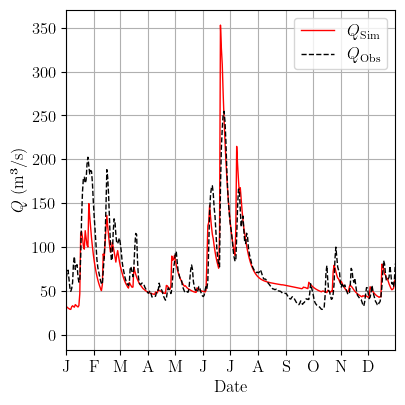

In [109]:
df_Qinc['Qobs'] = df_obs['Qobs'].replace(0, float('nan')).dropna()
xaxis = pd.date_range(start='2011-01-01', periods=len(df_Qinc), freq='D')

fig, ax = plt.subplots(figsize=(10/2.54, 10/2.54), constrained_layout=True)

ax.plot(xaxis, df_Qinc['86498+86499'].values, label='$Q_\mathrm{Sim}$', linewidth = 1, color='red')
ax.plot(xaxis, df_Qinc['Qobs'].values, label='$Q_\mathrm{Obs}$', linewidth = 1, color='black', linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('$Q$ (m³/s)')

ax.legend()

ax.grid(True)

ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))

plt.xticks()

plt.show()

Calculando indicadores para o período de 2012

In [68]:

def indicator(obs, sim):
    rmse_val = rmse(obs, sim)
    pbias_val = pbias(obs, sim)
    nashsutcliffe_val = nashsutcliffe(obs, sim)
    kge_val = kge(obs, sim)

    print(f"RMSE: {rmse_val:.1f}")
    print(f"PBIAS: {pbias_val:.1f}%")
    print(f"NSE: {nashsutcliffe_val:.3f}")
    print(f"KGE: {kge_val:.3f}")

# Example usage:
indicator(df_Qinc['Qobs'][365:], df_Qinc['86498+86499'][365:])



RMSE: 25.4
PBIAS: -4.8%
NSE: 0.650
KGE: 0.812


Verificação dos valores das parcelas de escoamento base e escoamento superficial direto

In [69]:
df_test = pd.DataFrame()

Verificação da vazão superficial direta e de base do modelo SMAP

In [70]:
df_test['Qb'] = models[0].Qb
df_test['Qd'] = models[0].Qd
df_test['Qt'] = models[0].Q

fig = df_test.plot()
fig.update_layout(legend_title='Legenda', legend=dict(y=1.1, orientation='h', itemsizing='constant'), font_family='CMU Serif', font=dict(size=12))
fig.update_xaxes(title_text='Tempo (dias)', title_font=dict(size=12))
fig.update_yaxes(title_text='Vazão (m³/s)', title_font=dict(size=12))
fig.update_layout(
    legend_title='Legenda',
    legend=dict(y=1.1, orientation='h', itemsizing='constant'),
    font_family='CMU Serif',
    font=dict(size=12),
    width=800,
    height=600
)

fig.show()


Configurando o modelo de acumulo e lavagem em bacias (Buildup/Washoff)

In [71]:
loadgens = []

for i in range(8):
    loadgen = buwo.BuildUpWashoff(landuse_name='',
                                  Bmax=df_data['Bmax'][i],
                                  Nb=df_data['Nb'][i],
                                  Kb=df_data['Kb'][i],
                                  threshold_flow=0.02,
                                  Nw=df_data['Nw'][i],
                                  Kw=df_data['Kw'][i],
                                  BuMethod=2,
                                  WoMethod=1,
                                  timestep_h=24,
                                  initial_buildup=1,
                                  area=df_data['AD'][i],
                                  area_fraction=1,
                                  surface_flow=df_Qd[codes[i]]/df_data['AD'][i]*86.4)
    loadgens.append(loadgen)

Convertendo dados de vazão de (**m³/s**) para (**mm/dia**)

In [72]:
df_Qmm = pd.DataFrame()

for i in range(8):
    df_Qmm[codes[i]] = df_Qd[codes[i]]/df_data['AD'][i]*86.4

Gráfico de Escoamento Superficial Direto para toda a região do estudo

In [73]:
fig = df_Qmm.plot()
fig.update_layout(
    xaxis_title='Tempo (dias)',
    yaxis_title='Vazão (mm/dia)',
    legend_title='Legenda',
    legend=dict(y=1.1, orientation='h', itemsizing='constant'),
    font_family='CMU Serif',
    font=dict(size=12),
    width=700,
    height=500
)
fig.show()


Download das estações, se `downloaded = True` será utilizado a planilha

In [74]:
stations = [64214200,
64214100,
64214050,
64214000,
64205000,
64200000,
64198010,
64198002,
64198000,
64191000,
64190800,
64190000,
64185000,
64183000,
64182000,
64181000,
64150000,
64149000,
64135001,
64135000,
64120100,
64120000,
64119500,
64119000,
64115000,
64114000,
64113000,
64112000,
64105800,
64105000,
64101000,
64100000,
64099000,
64098000,
64096000,
64095000,
64082000,
64081000,
64080000,
64075200,
64075100,
64075000,
64074800,
64066000,
64065000,
64040000,
64035000,
64030000,
64015000,
64014800,
64013000,
64012500,
64010000,
64007000,
64005000]
downloaded = True
if not downloaded:
    data_stations = hydrobr.get_data.ANA.flow_data(stations)
else:
    data_stations = pd.read_excel('flow_stations.xlsx', index_col=0, parse_dates=True)


In [75]:
disponib = hydrobr.Plot.gantt(data_stations)

Diagrama de disponibilidade de dados

In [76]:
if not downloaded:
    disponib.update_layout(
        autosize=False,
        width=1000,
        height=500,
        xaxis_title = 'Year',
        yaxis_title = 'Station Code',
        font=dict(family="Courier New, monospace", size=12))

In [77]:
data_stations = data_stations.loc['2012-01-01':'2012-12-31']
data_stations.dropna(axis=1, how='all', inplace=True)
data_stations.to_excel('flow_stations.xlsx')


In [78]:
disponib = hydrobr.Plot.gantt(data_stations)
disponib.update_layout(
    autosize=False,
    width=1000,
    height=500,
    xaxis_title = 'Year',
    yaxis_title = 'Station Code',
    font=dict(family="Courier New, monospace", size=12))

In [79]:
codes2 = ['86492', '86496', '86495']

In [80]:
catchment_station = {
    '86492': '64198000',
    '86496': '64119000',
    '86495': '64135000'
}

In [81]:
stations2 = ['64198000', '64119000', '64135000']

In [82]:
catchment_area = {
    '86492': 721.3625,
    '86496': 533.07,
    '86495': 622.855
}

In [83]:
calibrated = True

In [84]:
if not calibrated:
    basins2 = []
    for i in catchment_area.values():
        basin = SMAP.SMAP.Basin(AD=i)
        basins2.append(basin)   
else:
    df_data2 = pd.read_excel('case_calib2.xlsx')
    
    basins2 = []
    for i in range(3):
        basin = SMAP.SMAP.Basin(AD=df_data2['AD'][i],
                                Str=df_data2['Sat'][i],
                                Capc=df_data2['Capc'][i],
                                Crec=df_data2['Crec'][i],
                                TUin=df_data2['TUin'][i],
                                EBin=df_data2['EBin'][i],
                                k2t=df_data2['k2t'][i],
                                kkt=df_data2['kkt'][i],
                                Ai=df_data2['Ai'][i])
        basins2.append(basin)

In [85]:
basins2[0].kkt = 70


In [86]:
points2 = []
for station in catchment_station.keys():
    point = SMAP.SMAP.Point(df_prec[int(station)][365:].to_list(), df_etp[int(station)][365:].to_list())
    points2.append(point)

In [87]:
models2 = []

pcof = [1.4, 1.6, 1]
for i in range(3):
    for j in range(points2[i].n):
        points2[i].P[j] = points2[i].P[j] * pcof[i]
    
    model = SMAP.SMAP(points2[i], basins2[i])
    models2.append(model)

In [88]:
if not calibrated:
    calibs = []
    for i in range(3):
        calibs.append(models2[i].Calibrate(data_stations[stations2[i]],
                             objective_function='rmse',
                             optimization_engine = 'de'
                             )                   
                      )
else:
    for i in range(3):
        models2[i].RunModel() 

In [89]:
show_params = True

if show_params:
    for i in range(3):
        print(codes2[i])
        print(models2[i].Basin)
        print()

86492
SMAP Basin Object:
  Str = 250.0,
  Crec = 0.2,
  Capc = 0.4,
  kkt = 70,
  k2t = 10.0,
  Ai = 2.5,
  TUin = 0.01,
  EBin = 20.0,
  AD = 721.3625

86496
SMAP Basin Object:
  Str = 100.0,
  Crec = 0.16539120750691802,
  Capc = 0.3232,
  kkt = 77.7,
  k2t = 10.0,
  Ai = 2.5,
  TUin = 0.01,
  EBin = 15.0,
  AD = 533.07

86495
SMAP Basin Object:
  Str = 101.913,
  Crec = 0.034516,
  Capc = 0.31759160000000003,
  kkt = 101.6516,
  k2t = 3.2159736,
  Ai = 2.5,
  TUin = 0.0,
  EBin = 1.48,
  AD = 622.855



In [90]:
df_Q2 = pd.DataFrame()
for i in range(3):
    df_Q2[codes2[i]] = models2[i].Q

In [91]:
for i in range(3):
    print(f'Estação {codes2[i]}')
    print()
    print('Perído total')
    indicator(data_stations[stations2[i]], models2[i].Q)
    print('Período de 180 dias')
    indicator(data_stations[stations2[i]][:181], models2[i].Q[:181])
    print()

Estação 86492

Perído total
RMSE: 12.3
PBIAS: -1.6%
NSE: 0.155
KGE: 0.550
Período de 180 dias
RMSE: 12.5
PBIAS: -27.7%
NSE: 0.355
KGE: 0.570

Estação 86496

Perído total
RMSE: 9.6
PBIAS: -16.1%
NSE: 0.510
KGE: 0.731
Período de 180 dias
RMSE: 10.9
PBIAS: -15.4%
NSE: 0.522
KGE: 0.730

Estação 86495

Perído total
RMSE: 24.2
PBIAS: -0.1%
NSE: 0.297
KGE: 0.297
Período de 180 dias
RMSE: 32.2
PBIAS: -34.5%
NSE: 0.342
KGE: 0.206



In [92]:
for i in range(3):
    df_Q2[f'{codes2[i]}_Obs'] = data_stations[stations2[i]].values

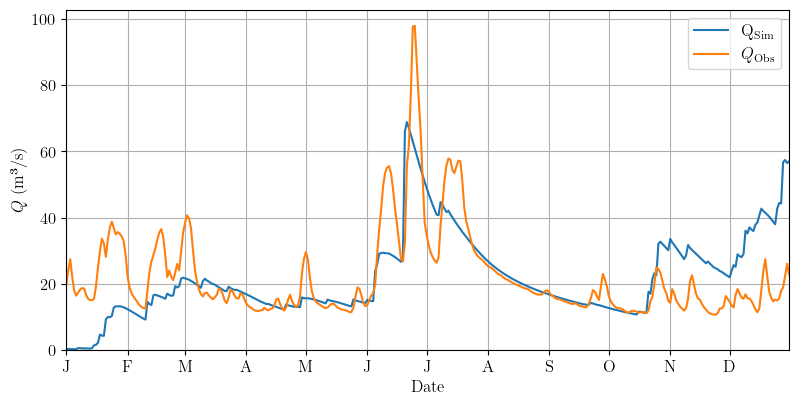

In [93]:
fig, ax = plt.subplots(figsize=(20/2.54, 10/2.54), constrained_layout=True)

xaxis = pd.date_range(start='2012-01-01', periods=len(df_Q2), freq='D')

# Graph for Sub-bacia 86492
ax.plot(xaxis, df_Q2[df_Q2.columns[0]].values, label='Q$_\mathrm{Sim}$')
ax.plot(xaxis, df_Q2[f'{df_Q2.columns[0]}_Obs'].values, label='$Q_\mathrm{Obs}$')
ax.legend()

# Set axis titles
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('$Q$ (m³/s)')

ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))
ax.set_ylim(0)
# plt.xticks(rotation=45)

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))

# plt.savefig('H:/GitHub/Thesis/images/case2/vazao86492.pdf')

plt.show()

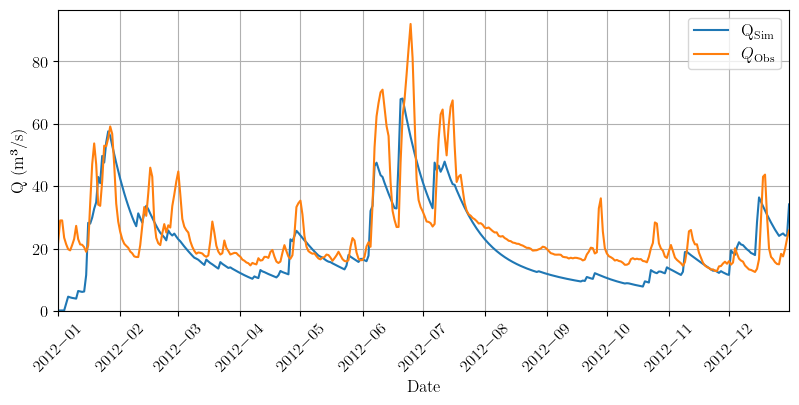

In [94]:
fig, ax = plt.subplots(figsize=(20/2.54, 10/2.54), constrained_layout=True)

xaxis = pd.date_range(start='2012-01-01', periods=len(df_Q2), freq='D')

# Graph for Sub-bacia 86496
ax.plot(xaxis, df_Q2[df_Q2.columns[1]].values, label='Q$_\mathrm{Sim}$')
ax.plot(xaxis, df_Q2[f'{df_Q2.columns[1]}_Obs'].values, label='$Q_\mathrm{Obs}$')
ax.legend()

# Set axis titles
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Q (m³/s)')

ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))
ax.set_ylim(0)
plt.xticks(rotation=45)

# plt.savefig('H:/GitHub/Thesis/images/case2/vazao86496.pdf')

plt.show()

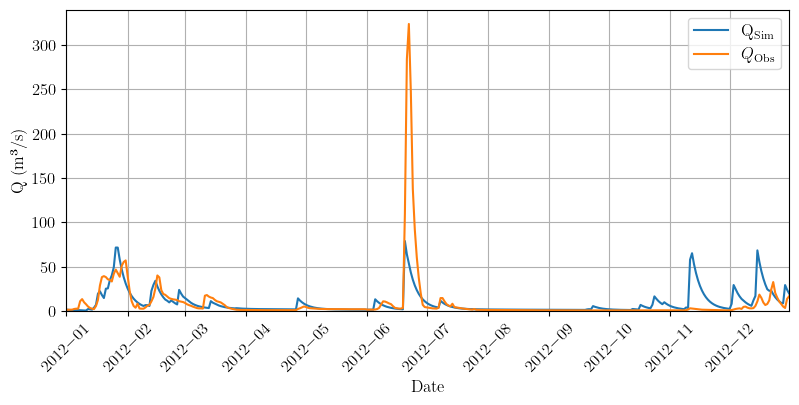

In [95]:
fig, ax = plt.subplots(figsize=(20/2.54, 10/2.54), constrained_layout=True)

xaxis = pd.date_range(start='2012-01-01', periods=len(df_Q2), freq='D')

# Graph for Sub-bacia 86496
ax.plot(xaxis, df_Q2[df_Q2.columns[2]].values, label='Q$_\mathrm{Sim}$')
ax.plot(xaxis, df_Q2[f'{df_Q2.columns[2]}_Obs'].values, label='$Q_\mathrm{Obs}$')
ax.legend()

# Set axis titles
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Q (m³/s)')

ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))
ax.set_ylim(0)
plt.xticks(rotation=45)

# plt.savefig('H:/GitHub/Thesis/images/case2/vazao86495.pdf')

plt.show()

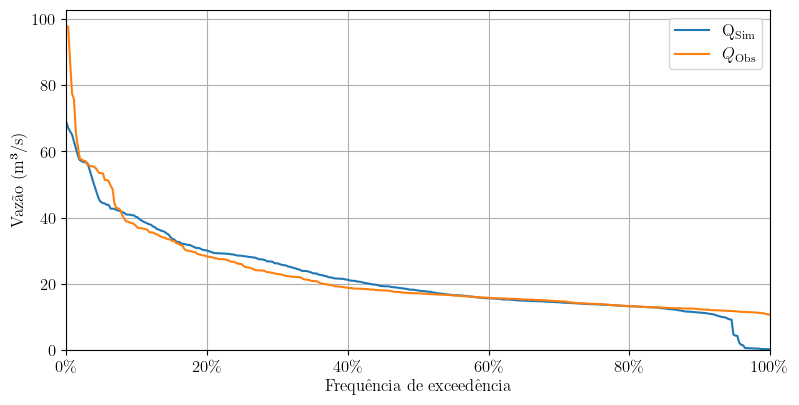

In [96]:
from matplotlib.ticker import PercentFormatter 

fig, ax = plt.subplots(figsize=(20/2.54, 10/2.54), constrained_layout=True)

perc = np.linspace(0,1,len(df_Q2))
# Graph for Sub-bacia 86496
ax.plot(perc, df_Q2[df_Q2.columns[0]].sort_values(ascending=False).values, label='Q$_\mathrm{Sim}$')
ax.plot(perc, df_Q2[f'{df_Q2.columns[0]}_Obs'].sort_values(ascending=False).values, label='$Q_\mathrm{Obs}$')
ax.legend()

# Set axis titles
ax.grid(True)
ax.set_xlabel('Frequência de exceedência')
ax.set_ylabel('Vazão (m³/s)')
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

ax.set_xlim(0, 1)
ax.set_ylim(0)
# plt.xticks(rotation=45)

# plt.savefig('H:/GitHub/Thesis/images/case2/perm86492.pdf')

plt.show()

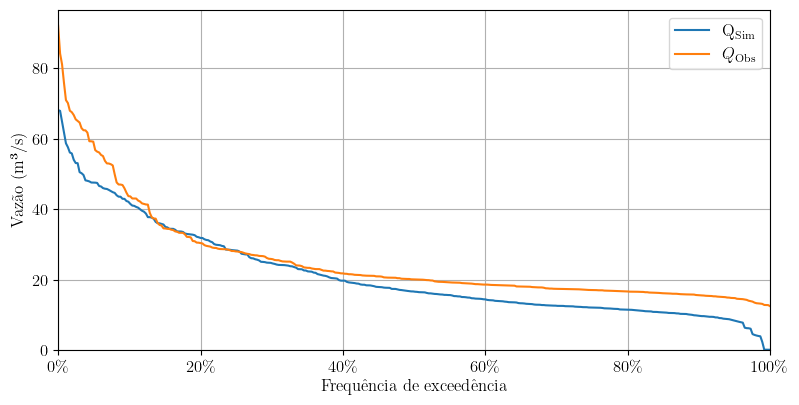

In [97]:
from matplotlib.ticker import PercentFormatter 

fig, ax = plt.subplots(figsize=(20/2.54, 10/2.54), constrained_layout=True)

perc = np.linspace(0,1,len(df_Q2))
# Graph for Sub-bacia 86496
ax.plot(perc, df_Q2[df_Q2.columns[1]].sort_values(ascending=False).values, label='Q$_\mathrm{Sim}$')
ax.plot(perc, df_Q2[f'{df_Q2.columns[1]}_Obs'].sort_values(ascending=False).values, label='$Q_\mathrm{Obs}$')
ax.legend()

# Set axis titles
ax.grid(True)
ax.set_xlabel('Frequência de exceedência')
ax.set_ylabel('Vazão (m³/s)')
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

ax.set_xlim(0, 1)
ax.set_ylim(0)
# plt.xticks(rotation=45)

# plt.savefig('H:/GitHub/Thesis/images/case2/perm86496.pdf')

plt.show()

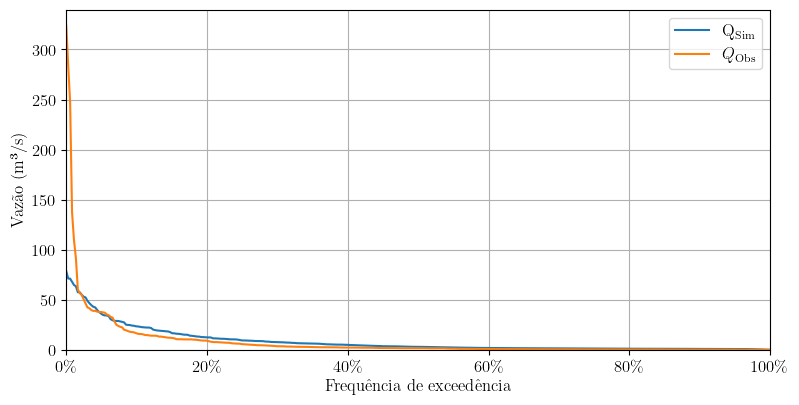

In [98]:
from matplotlib.ticker import PercentFormatter 

fig, ax = plt.subplots(figsize=(20/2.54, 10/2.54), constrained_layout=True)

perc = np.linspace(0,1,len(df_Q2))
# Graph for Sub-bacia 86496
ax.plot(perc, df_Q2[df_Q2.columns[2]].sort_values(ascending=False).values, label='Q$_\mathrm{Sim}$')
ax.plot(perc, df_Q2[f'{df_Q2.columns[2]}_Obs'].sort_values(ascending=False).values, label='$Q_\mathrm{Obs}$')
ax.legend()

# Set axis titles
ax.grid(True)
ax.set_xlabel('Frequência de exceedência')
ax.set_ylabel('Vazão (m³/s)')
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

ax.set_xlim(0, 1)
ax.set_ylim(0)
# plt.xticks(rotation=45)

# plt.savefig('H:/GitHub/Thesis/images/case2/perm86495.pdf')

plt.show()

### Calibração das bacias 83 e 84

Estratégia: utilização das vazões afluentes do reservatório de Jurumirim

In [99]:
df_jurumirim = pd.read_excel('Qjurumirim.xlsx')

In [100]:
columns = [86492, 86493, 86494, 86495, 86496, 86497, 86498, 86499]
missing_columns = [col for col in columns if col not in df_Qinc.columns]
if missing_columns:
    print(f"One or more columns are missing in df_Qinc: {missing_columns}")
else:
    df_Qinc['Total'] = df_Qinc[columns].sum(axis=1)


In [101]:
df_total = pd.DataFrame()
df_total['SMAP'] = df_Qinc['Total'][365:].values
df_total['Jurumirim'] = df_jurumirim['Qafl'].values
df_total['Jurumirim_nat'] = df_jurumirim['Qnat'].values
df_total['SMAP_musk'] = Muskingum.Muskingum.downstream_routing(df_total.SMAP.values, 1.6, .25, 1)

In [102]:
df_calib_t = pd.DataFrame()
df_calib_t['Q'] = (df_total['Jurumirim'].values - df_Qinc[86492][365:].values 
                     - df_Qinc[86495][365:].values
                     - df_Qinc[86496][365:].values - df_Qinc[86497][365:].values
                     - df_Qinc[86498][365:].values - df_Qinc[86499][365:].values)
df_calib_t['Q2'] = (df_total['Jurumirim'].values - df_Qinc[86499][365:].values - df_Qinc[86498][365:].values )

In [103]:
dif = df_total['SMAP'].sum() - df_total['Jurumirim'].sum()
print(f'{dif:.1f}')

5429.0


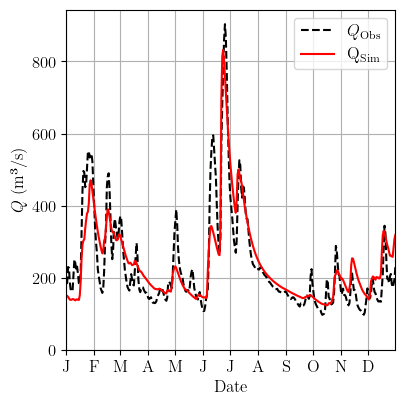

In [107]:
fig, ax = plt.subplots(figsize=(10/2.54, 10/2.54), constrained_layout=True)

xaxis = pd.date_range(start='2012-01-01', periods=len(df_Q2), freq='D')

# Graph for Sub-bacia 86496
# ax.plot(xaxis, df_total['SMAP'].values, label='Q$_\mathrm{Sim-SMAP}$')
ax.plot(xaxis, df_total['Jurumirim_nat'].values, linestyle='--', label='$Q_\mathrm{Obs}$', color='black')
ax.plot(xaxis, df_total['SMAP_musk'].values, label='Q$_\mathrm{Sim}$', color='red')

ax.legend()

# Set axis titles
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('$Q$ (m³/s)')

ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))
ax.set_ylim(0)
# plt.xticks(rotation=45)
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
# plt.savefig('H:/GitHub/Thesis/images/case2/Qtotal.pdf')

plt.show()

In [105]:
indicator(df_total['Jurumirim'], df_total['SMAP'])

RMSE: 73.3
PBIAS: 6.5%
NSE: 0.746
KGE: 0.778
